In [2]:
import pickle
from tqdm import tqdm
import numpy as np
from utils import load_caption, decode_caption, load_vocab, print_image
import os

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from prepare_captions import preprocess_json_files
%matplotlib inline
plt.style.use('ggplot')

In [3]:
vocab = load_vocab('/home/spb61/coco2014_vocab.json')

word_to_idx
idx_to_word
Loaded dictionary...
Dictionary size: 5004


# Captions found in training data

In [60]:
annotations_dir='/home/spb61/annotations'
annotations_file='captions_train2014.json'

train_annotations = preprocess_json_files(annotations_dir)[annotations_file][0]
train_annotations = [' '.join(c) for c in train_annotations]
print("Found {} training captions".format(len(train_annotations)))

Skipping file person_keypoints_train2014.json
Skipping file instances_train2014.json
Found 414113 training captions


In [5]:
train_unique_captions, train_indices, train_counts = np.unique(train_annotations, 
                                                               return_counts=True, 
                                                               return_inverse=True)

In [6]:
print(len(train_unique_captions), len(train_unique_captions) / len(train_annotations) * 100)
sort_indices = np.argsort(train_counts)[::-1]
for i in sort_indices[:10]:
    print(train_counts[i], train_unique_captions[i])
print(train_counts[sort_indices][:10])

399483 96.46714785577849
115 a man riding a wave on top of a surfboard
101 a man flying through the air while riding a skateboard
96 a man riding skis down a snow covered slope
83 a large long train on a steel track
80 a man holding a tennis racquet on a tennis court
63 a man standing on a tennis court holding a racquet
54 a person on a court with a tennis racket
53 a man riding a snowboard down a snow covered slope
52 a man flying through the air while riding a snowboard
52 a person riding a surf board on a wave
[115 101  96  83  80  63  54  53  52  52]


# Beam generated captions

In [7]:
def unique_beam_captions(k = 10):
    beams = pickle.load(open('/datadrive/beams_{}.pickle'.format(k),'rb'))
    beam_captions = []
    for image_id, cap in tqdm(beams.items()):
        beam_captions.append(' '.join(decode_caption(cap[0]['sentence'], vocab)))
    beam_captions = np.array(beam_captions)
    unique_captions, indices, counts = np.unique(beam_captions, return_counts=True, return_inverse=True)
    print("# unique captions: {}\t{}%".format(len(unique_captions), 100*len(unique_captions)/len(beam_captions)))
    sort_indices = np.argsort(counts)[::-1]
    return unique_captions, indices, counts, sort_indices

Beam size: 1


100%|██████████| 40504/40504 [00:00<00:00, 444943.47it/s]


# unique captions: 9141	22.568141418131543%
Counts == 1: 5421
Counts > 1: 3720

Beam size: 2


100%|██████████| 40504/40504 [00:00<00:00, 390714.29it/s]


# unique captions: 9208	22.733557179537822%
Counts == 1: 5491
Counts > 1: 3717

Beam size: 10


100%|██████████| 40504/40504 [00:00<00:00, 341303.95it/s]


# unique captions: 5488	13.549279083547304%


100%|██████████| 40504/40504 [00:00<00:00, 329355.33it/s]


Counts == 1: 2888
Counts > 1: 2600

Beam size: 100
# unique captions: 4150	10.245901639344263%
Counts == 1: 1955
Counts > 1: 2195



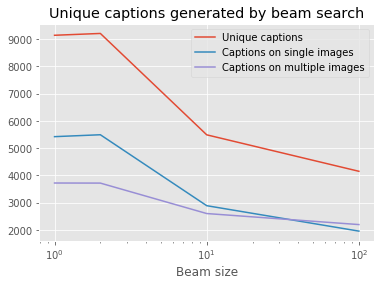

In [8]:
unique_beam_caps = []
one_image_beam_caps = []
multiple_images_beam_caps = []
for k in [1,2,10,100]:
    print("Beam size:", k)
    unique_captions, indices, counts, sort_indices = unique_beam_captions(k)
    unique_beam_caps.append(len(unique_captions))
    one_image_beam_caps.append(sum(counts==1))
    multiple_images_beam_caps.append(sum(counts > 1))
    print("Counts == 1:", sum(counts == 1))
    print("Counts > 1:", sum(counts > 1))
    print()
    
plt.plot([1,2,10,100], unique_beam_caps, label="Unique captions")
plt.plot([1,2,10,100], one_image_beam_caps, label="Captions on single images")
plt.plot([1,2,10,100], multiple_images_beam_caps, label="Captions on multiple images")
plt.xscale('log')
plt.xlabel('Beam size')
plt.legend()
plt.title("Unique captions generated by beam search")
plt.savefig("../outputs/figs/unique_beam_captions.png", bbox_inches='tight')

In [9]:
unique_captions2, indices2, counts2, sort_indices2 = unique_beam_captions(2)
unique_captions100, indices100, counts100, sort_indices100 = unique_beam_captions(100)

100%|██████████| 40504/40504 [00:00<00:00, 391829.92it/s]


# unique captions: 9208	22.733557179537822%


100%|██████████| 40504/40504 [00:00<00:00, 327392.17it/s]


# unique captions: 4150	10.245901639344263%


In [10]:
print(counts100[unique_captions100 == "a man riding a wave on top of a surfboard"])

[727]


In [11]:
for count, cap, index in zip(counts2[sort_indices2], unique_captions2[sort_indices2][:10], indices):
    count100 = counts100[unique_captions100 == cap]
    count100 = count100[0] if len(count100) > 0 else 0
    count_train = train_counts[train_unique_captions == cap]
    count_train = count_train[0] if len(count_train) > 0 else 0
    print("{} & {} & {} & {}\\\\".format(cap, count, count100, count_train))
    


a man riding a wave on top of a surfboard & 642 & 727 & 115\\
a bathroom with a toilet and a sink & 596 & 341 & 9\\
a tennis player to hit the ball & 507 & 0 & 0\\
a baseball player swinging a bat at a ball & 491 & 362 & 31\\
a man riding a skateboard down the side of a ramp & 332 & 159 & 29\\
a man riding skis down a snow covered slope & 330 & 614 & 96\\
a living room filled with furniture and a fire place & 322 & 446 & 14\\
a group of people sitting around a table & 261 & 300 & 13\\
a bathroom with a sink and a mirror & 239 & 140 & 6\\
a man riding a skateboard up the side of a ramp & 231 & 191 & 46\\


In [51]:
intersection_2 = np.intersect1d(unique_captions2, train_annotations)
print(len(intersection_2), len(unique_captions2), len(intersection_2)/len(unique_captions2))

1391 9208 0.1510642919200695


In [49]:
for count, cap, index in zip(counts100[sort_indices100], unique_captions100[sort_indices100][:10], indices100):
    count2 = counts2[unique_captions2 == cap]
    count2 = count2[0] if len(count2) > 0 else 0
    count_train = train_counts[train_unique_captions == cap]
    count_train = count_train[0] if len(count_train) > 0 else 0
    print("{} & {} & {} & {}\\\\".format(cap, count, count2, count_train))


a large long train on a steel track & 784 & 1 & 83\\
a man riding a wave on top of a surfboard & 727 & 642 & 115\\
a man riding skis down a snow covered slope & 614 & 330 & 96\\
a public transit bus on a city street & 577 & 0 & 34\\
a man holding a tennis racquet on a tennis court & 552 & 146 & 80\\
a couple of giraffe standing next to each other & 469 & 1 & 32\\
a red stop sign sitting on the side of a road & 459 & 200 & 37\\
a living room filled with furniture and a fire place & 446 & 322 & 14\\
a city street filled with lots of traffic & 417 & 113 & 12\\
a laptop computer sitting on top of a wooden desk & 395 & 174 & 22\\


In [50]:
intersection_100 = np.intersect1d(unique_captions100, train_annotations)
print(len(intersection_100), len(unique_captions100), len(intersection_100)/len(unique_captions100))

1272 4150 0.30650602409638555


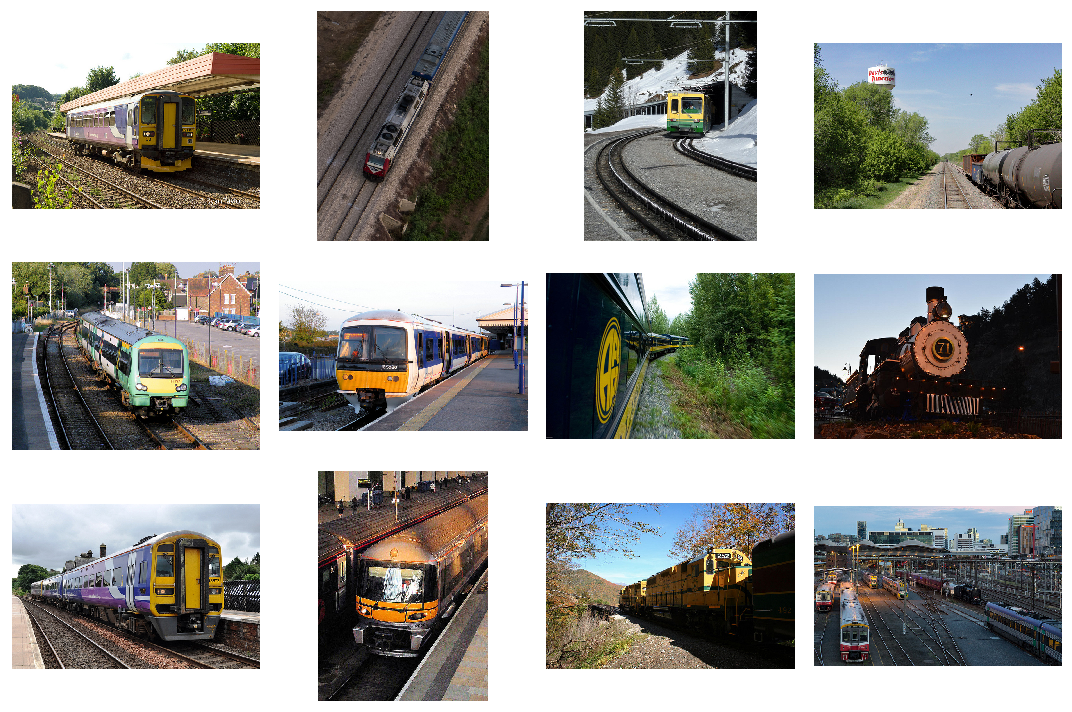

In [13]:
fig = plt.figure(figsize=(15,10))
for i, image_id in enumerate(np.where(indices100 == sort_indices100[0])[0][:12]):
    axes = fig.add_subplot(3,4,i+1)
    axes.imshow(mpimg.imread(os.path.join('/home/spb61/val_2014/', "{}.jpg".format(image_id))))
    axes.set_xticks([])
    axes.set_yticks([])
plt.tight_layout()
# plt.savefig("../outputs/figs/most_common_beam_images.png", bbox_inches='tight')

# vote generated captions

In [14]:
def unique_vote_captions(k = 10, pickle_file = '../outputs/vote_captions_{}_bigram_precision.pickle'):
    votes = pickle.load(open(pickle_file.format(k),'rb'))
    vote_captions = []
    for image_id, cap in tqdm(votes.items()):
        vote_captions.append(' '.join(decode_caption(cap[0][0], vocab)))
    vote_captions = np.array(vote_captions)
    unique_captions, indices, counts = np.unique(vote_captions, return_counts=True, return_inverse=True)
    print("# unique captions: {}\t{}%".format(len(unique_captions), 100*len(unique_captions)/len(vote_captions)))
    sort_indices = np.argsort(counts)[::-1]
    return unique_captions, indices, counts, sort_indices

In [15]:
unique_vote_caps = {}
one_image_vote_caps = {}
multiple_images_vote_caps = {}

for similarity in ['hidden', 'unigram_precision', 'unigram_overlap', 'bigram_precision', 'bigram_overlap' ]:
    pickle_file = '../outputs/vote_captions_{}_' + similarity + '.pickle'
    
    unique_votes = []
    ones = []
    multiples = []
    for k in [1,2,10,100]:
        print("Beam size:", k)
        unique_captions, indices, counts, sort_indices = unique_vote_captions(k, pickle_file)
        unique_votes.append(len(unique_captions))
        ones.append(sum(counts==1))
        multiples.append(sum(counts > 1))
        print("Counts == 1:", sum(counts == 1))
        print("Counts > 1:", sum(counts > 1))
        print()
        
    unique_vote_caps[similarity] = unique_votes
    one_image_vote_caps[similarity] = ones
    multiple_images_vote_caps[similarity] = multiples
    
unique_vote_caps['beam'] = unique_beam_caps
one_image_vote_caps['beam'] = one_image_beam_caps
multiple_images_vote_caps['beam'] = multiple_images_beam_caps

  0%|          | 0/40504 [00:00<?, ?it/s]

Beam size: 1


  0%|          | 0/40504 [00:00<?, ?it/s]

# unique captions: 9141	22.568141418131543%
Counts == 1: 5421
Counts > 1: 3720

Beam size: 2


100%|██████████| 40504/40504 [00:00<00:00, 162941.21it/s]


# unique captions: 12333	30.44884455856212%
Counts == 1: 7784
Counts > 1: 4549

Beam size: 10


100%|██████████| 40504/40504 [00:00<00:00, 161964.41it/s]


# unique captions: 11818	29.177365198498915%
Counts == 1: 7173
Counts > 1: 4645

Beam size: 100


100%|██████████| 40504/40504 [00:00<00:00, 157411.39it/s]


# unique captions: 8796	21.71637369148726%
Counts == 1: 5122
Counts > 1: 3674

Beam size: 1


  0%|          | 0/40504 [00:00<?, ?it/s]

# unique captions: 9141	22.568141418131543%
Counts == 1: 5421
Counts > 1: 3720

Beam size: 2


  0%|          | 0/40504 [00:00<?, ?it/s]

# unique captions: 10727	26.483804068733953%
Counts == 1: 6656
Counts > 1: 4071

Beam size: 10


  0%|          | 0/40504 [00:00<?, ?it/s]

# unique captions: 8902	21.978076239383764%
Counts == 1: 5244
Counts > 1: 3658

Beam size: 100


100%|██████████| 40504/40504 [00:00<00:00, 145786.05it/s]


# unique captions: 10769	26.58749753110804%
Counts == 1: 6590
Counts > 1: 4179

Beam size: 1


100%|██████████| 40504/40504 [00:00<00:00, 169097.08it/s]


# unique captions: 9141	22.568141418131543%
Counts == 1: 5421
Counts > 1: 3720

Beam size: 2


100%|██████████| 40504/40504 [00:00<00:00, 160839.81it/s]


# unique captions: 10727	26.483804068733953%
Counts == 1: 6662
Counts > 1: 4065

Beam size: 10


100%|██████████| 40504/40504 [00:00<00:00, 152714.97it/s]


# unique captions: 8916	22.012640726841795%
Counts == 1: 5273
Counts > 1: 3643

Beam size: 100


100%|██████████| 40504/40504 [00:00<00:00, 142749.90it/s]


# unique captions: 10811	26.691190993482124%
Counts == 1: 6661
Counts > 1: 4150

Beam size: 1


100%|██████████| 40504/40504 [00:00<00:00, 166083.28it/s]


# unique captions: 9141	22.568141418131543%
Counts == 1: 5421
Counts > 1: 3720

Beam size: 2


100%|██████████| 40504/40504 [00:00<00:00, 162035.01it/s]


# unique captions: 9522	23.508789255382183%
Counts == 1: 5733
Counts > 1: 3789

Beam size: 10


100%|██████████| 40504/40504 [00:00<00:00, 155427.59it/s]


# unique captions: 7590	18.738889986174204%
Counts == 1: 4361
Counts > 1: 3229

Beam size: 100


100%|██████████| 40504/40504 [00:00<00:00, 151038.45it/s]


# unique captions: 9247	22.829843966028047%
Counts == 1: 5413
Counts > 1: 3834

Beam size: 1


100%|██████████| 40504/40504 [00:00<00:00, 168658.59it/s]


# unique captions: 9141	22.568141418131543%
Counts == 1: 5421
Counts > 1: 3720

Beam size: 2


100%|██████████| 40504/40504 [00:00<00:00, 163071.81it/s]


# unique captions: 9519	23.501382579498323%
Counts == 1: 5731
Counts > 1: 3788

Beam size: 10


100%|██████████| 40504/40504 [00:00<00:00, 156145.16it/s]


# unique captions: 7598	18.758641121864507%
Counts == 1: 4369
Counts > 1: 3229

Beam size: 100


100%|██████████| 40504/40504 [00:00<00:00, 150634.01it/s]


# unique captions: 9220	22.76318388307328%
Counts == 1: 5368
Counts > 1: 3852



In [16]:
print(unique_vote_caps)
print(one_image_vote_caps)
print(multiple_images_vote_caps)

{'bigram_precision': [9141, 9522, 7590, 9247], 'bigram_overlap': [9141, 9519, 7598, 9220], 'hidden': [9141, 12333, 11818, 8796], 'unigram_precision': [9141, 10727, 8902, 10769], 'unigram_overlap': [9141, 10727, 8916, 10811], 'beam': [9141, 9208, 5488, 4150]}
{'bigram_precision': [5421, 5733, 4361, 5413], 'bigram_overlap': [5421, 5731, 4369, 5368], 'hidden': [5421, 7784, 7173, 5122], 'unigram_precision': [5421, 6656, 5244, 6590], 'unigram_overlap': [5421, 6662, 5273, 6661], 'beam': [5421, 5491, 2888, 1955]}
{'bigram_precision': [3720, 3789, 3229, 3834], 'bigram_overlap': [3720, 3788, 3229, 3852], 'hidden': [3720, 4549, 4645, 3674], 'unigram_precision': [3720, 4071, 3658, 4179], 'unigram_overlap': [3720, 4065, 3643, 4150], 'beam': [3720, 3717, 2600, 2195]}


beam [9141, 9208, 5488, 4150]
bigram_overlap [9141, 9519, 7598, 9220]
bigram_precision [9141, 9522, 7590, 9247]
hidden [9141, 12333, 11818, 8796]
unigram_overlap [9141, 10727, 8916, 10811]
unigram_precision [9141, 10727, 8902, 10769]


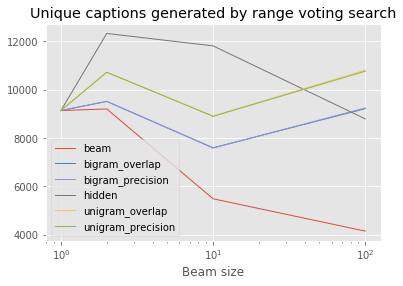

In [17]:
for similarity in sorted(unique_vote_caps):
    print(similarity, unique_vote_caps[similarity])
    plt.plot([1,2,10,100], unique_vote_caps[similarity], linewidth=1, linestyle='-', label=similarity)
    # plt.plot([1,2,10,100], multiple_images_vote_caps, label="Captions on multiple images")
    
plt.title("Unique captions generated by range voting search")
plt.xscale('log')
plt.xlabel('Beam size')
plt.legend(loc='lower left')
# plt.ylim([0, 13000])
# plt.savefig("../outputs/figs/unique_vote_captions.png", bbox_inches='tight')

beam [9141, 9208, 5488, 4150]
bigram_overlap [9141, 9519, 7598, 9220]
bigram_precision [9141, 9522, 7590, 9247]
hidden [9141, 12333, 11818, 8796]
unigram_overlap [9141, 10727, 8916, 10811]
unigram_precision [9141, 10727, 8902, 10769]


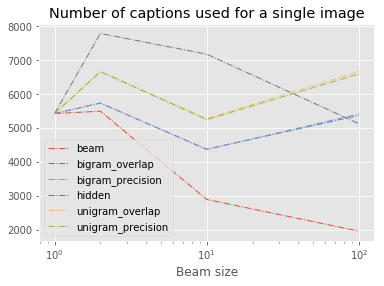

In [18]:
for similarity in sorted(unique_vote_caps):
    print(similarity, unique_vote_caps[similarity])
    plt.plot([1,2,10,100], one_image_vote_caps[similarity], linewidth=1, linestyle='-.', label=similarity)
    
plt.title("Number of captions used for a single image")
plt.xscale('log')
plt.xlabel('Beam size')
plt.legend(loc='lower left')
# plt.ylim([0, 13000])
plt.savefig("../outputs/figs/unique_vote_single_image_captions.png", bbox_inches='tight')

In [53]:
unique_captions, indices, counts, sort_indices = unique_vote_captions(100, '../outputs/vote_captions_{}_bigram_precision.pickle')

100%|██████████| 40504/40504 [00:00<00:00, 149284.39it/s]


# unique captions: 9247	22.829843966028047%


In [54]:
for count, cap, index in zip(counts[sort_indices], unique_captions[sort_indices][:10], indices):
    count_train = train_counts[train_unique_captions == cap]
    count_train = count_train[0] if len(count_train) > 0 else 0
    print("{} & {} & {}\\\\".format(cap, count, count_train))

a man riding a wave on top of a surfboard in the ocean & 643 & 7\\
a close up of a plate of food on a table & 478 & 13\\
a man holding a tennis racquet on a tennis court & 468 & 80\\
a man riding skis down a snow covered slope & 407 & 96\\
a hands train that is pulling into a train station & 293 & 0\\
a laptop computer sitting on top of a wooden desk & 274 & 22\\
a baseball player swinging a bat at a ball & 249 & 31\\
a man riding a skateboard down the side of a ramp & 244 & 29\\
a living room filled with furniture and a flat screen tv & 243 & 15\\
a living room filled with furniture and a fire place & 233 & 14\\


In [55]:
# TODO: percentage found in training!

In [56]:
vote_captions_pickle = pickle.load(open('../outputs/vote_captions_100_bigram_precision.pickle','rb'))
vote_captions = [' '.join(decode_caption(c[0][0], vocab)) for c in vote_captions_pickle.values()]

In [57]:
print(train_annotations[2])
print(unique_captions[2])

a blue and white bathroom with butterfly themed wall tiles
a airplane that is sitting on top of a runway


In [58]:
intersection = np.intersect1d(unique_captions, train_annotations)

In [59]:
print(len(intersection), len(unique_captions), len(intersection) / len(unique_captions))

1444 9247 0.15615875419054828
